# Case 1: House price prediction

In this case (Part II), there are two main tasks:

- First, you will need to split the train data into train and validate data and tune the model hyperparameters to choose the best model. Submit the predicted prices for test data to Kaggle to compete for Prof. X's Prize! You need to select up to 2 submissions to be evaluated for your final leaderboard score. The evaluated submission with the best Private Score is used for your final score.

- Then you will examine the profit of the iBuyer business model based on the predicted price on the valid data.






You need to submit a report in pdf format containing the following material on canvas site:

1.   A plot of the training errors and validation errors over epochs for a base multilayer perceptron model with 2 hidden layers of sizes 256 and 128.

2.   A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64.

3.  A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization.

4. A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization and dropout layers.

5. A table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.

6. Your profit analysis of the iBuyer business model based on the predicted price on the valid data and answers to the four questions therein.

You should also provide interpretations and implications of each plot/table in your report. It is not enough to simply put a chart or a table of numbers in the report and expect the audience to understand what the chart means and what it implies. The point is to provide some insights for an audience like senior management at Zillow.

You also need to submit on canvas site:

- The complete Juyputer notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.
-  A checkpoint.pth file containing all the necessary information to retrieve your best model and predictions.



---
## Data Loading and Visualize Data

The train data and test data are available on Kaggle website.
You can first download them, then upload them to the google colab, and then read the data using pandas.

In [108]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
#TODO: Read the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [109]:
# Display the train dataframe
print(train_df.shape)
print(train_df.columns)

(11581, 17)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS', 'SALE_PRICE'],
      dtype='object')


In [110]:
# Display the test dataframe
print(test_df.shape)
print(test_df.columns)

(4964, 16)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS'],
      dtype='object')


As you can see, we have 11581 training samples and 4964 test samples, each with 16 features. The training samples contain the sale_prices, which are the labels. The test samples do not contain the sale_prices, which we will predict by building a MLP model.


### Visualization of SALE PRICES

Let's take a closer look at the sale prices in the train data.

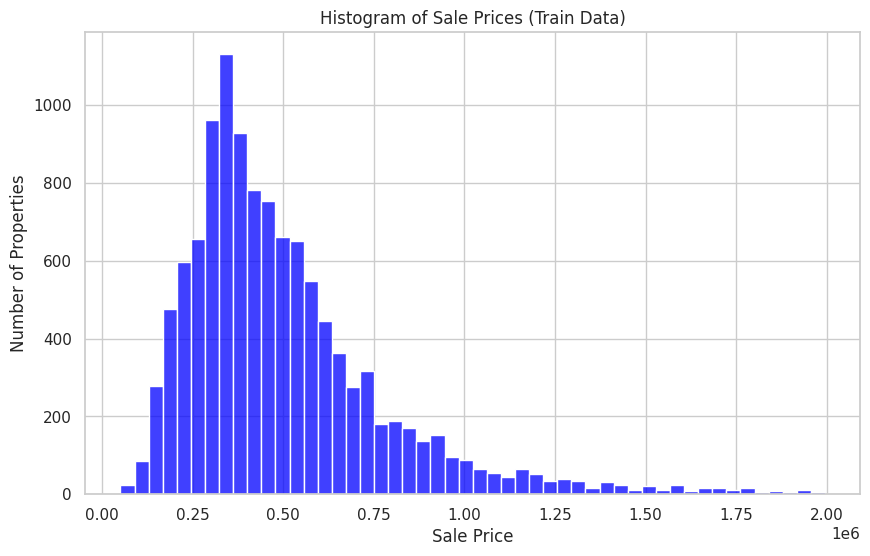

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot, it provides a MATLAB-like interface for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

Check the minimum and maximum sale_price in train data.

In [112]:
print(train_df['SALE_PRICE'].min())
print(train_df['SALE_PRICE'].max())
print(train_df['SALE_PRICE'].median())

51000
1995000
431000.0


We see that the sale_price has a wide range from 50K to 2 million, with the median price 431K.

In [113]:
upper_limit = train_df['SALE_PRICE'].quantile(0.99)  # top 1%

outliers_high = (train_df['SALE_PRICE'] > upper_limit).sum()

print(f"High outliers: {outliers_high}")
print(f"Remove prices above: ${upper_limit:,.0f}")

train_df = train_df[
    (train_df['SALE_PRICE'] <= upper_limit)]

High outliers: 116
Remove prices above: $1,585,800


### Visualization of Correlation

We can also compute and visualize the correlation matrix.

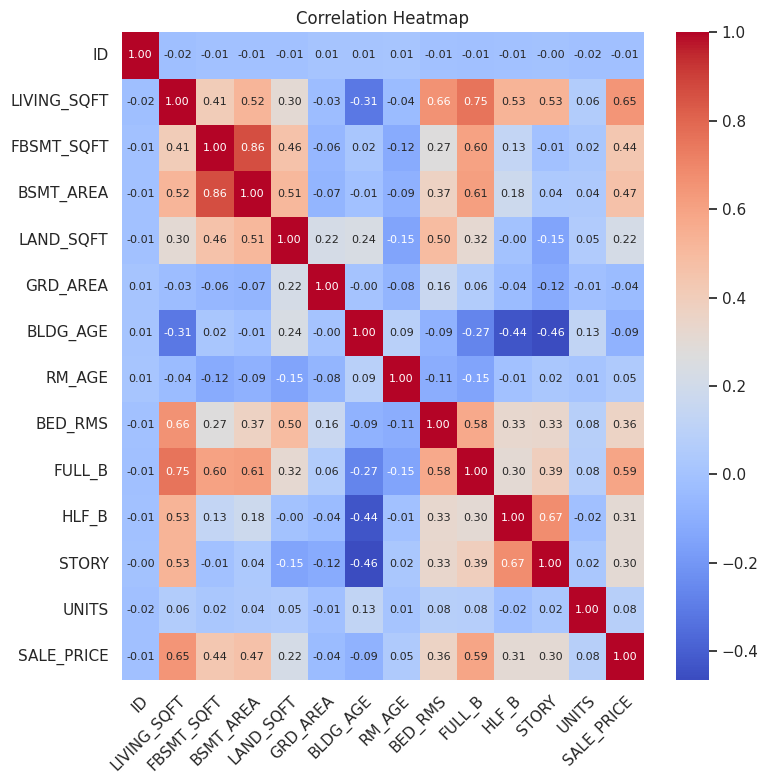

In [114]:
# Compute the correlation matrix:
correlation_matrix = train_df.corr(numeric_only=True)

# 1. Increase the figure size for clarity
plt.figure(figsize=(8, 8))

# 2. Use a heatmap with annotations, a color map, and specific formatting for the annotations
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

# 3. Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=0)

# 4. Title and display
plt.title('Correlation Heatmap')
plt.tight_layout()  # This can help if any labels are still being cut off
plt.show()

# 5. Optionally save the figure with high resolution
# plt.savefig("heatmap.png", dpi=300)

We can see that the Sale_Price has high correlation with Living_SQFT and number of Full Bathrooms.

### Distribution of houses over different NBHD

In [115]:
# Compute the number of houses per neighborhood
House_by_NBHD = train_df['NBHD'].value_counts()
print(House_by_NBHD )

NBHD
CENTRAL PARK                    1049
GATEWAY / GREEN VALLEY RANCH     937
UNION STATION                    366
HAMPDEN                          346
WINDSOR                          316
                                ... 
VALVERDE                          22
GLOBEVILLE                        20
SUN VALLEY                         8
CORY - MERRILL                     4
AURARIA                            1
Name: count, Length: 75, dtype: int64


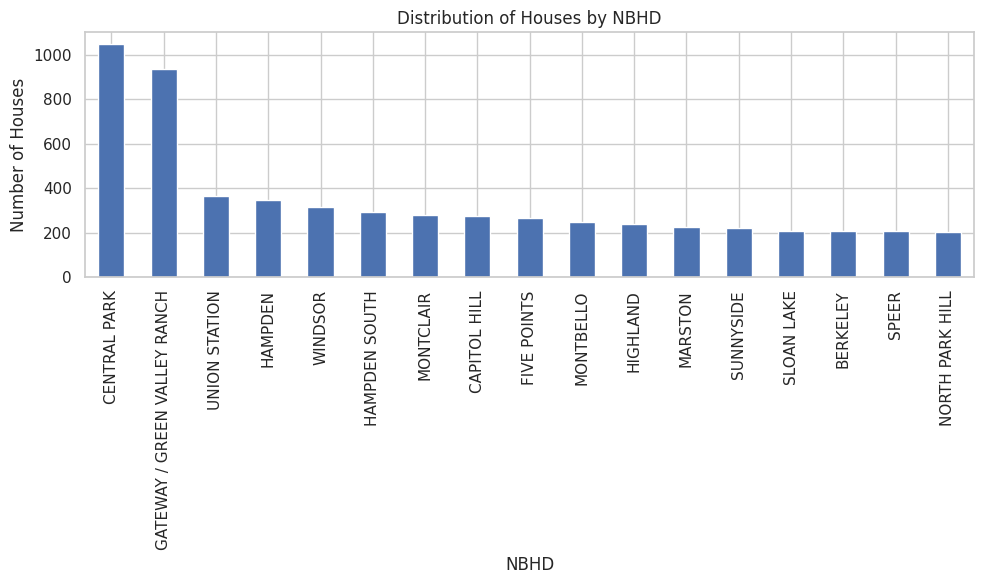

In [116]:
# Filtering ZIP codes that appear more than once
filtered_House_by_NBHD = House_by_NBHD[House_by_NBHD > 200]
filtered_House_by_NBHD.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Houses by NBHD')
plt.ylabel('Number of Houses')
plt.xlabel('NBHD')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability, if necessary
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()


---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- Train labels: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. Note that here we combine the feature vectors in the train and test data. In this way, the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

In [117]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4964 non-null   int64  
 1   NBHD         4964 non-null   object 
 2   PROP_CLASS   4964 non-null   object 
 3   LIVING_SQFT  4964 non-null   int64  
 4   FBSMT_SQFT   4964 non-null   int64  
 5   BSMT_AREA    4964 non-null   int64  
 6   LAND_SQFT    4964 non-null   int64  
 7   GRD_AREA     4964 non-null   int64  
 8   BLDG_AGE     4964 non-null   int64  
 9   RM_AGE       2623 non-null   float64
 10  BED_RMS      4964 non-null   float64
 11  FULL_B       4964 non-null   float64
 12  HLF_B        4964 non-null   int64  
 13  STORY        4964 non-null   float64
 14  STYLE_CN     4964 non-null   object 
 15  UNITS        4964 non-null   float64
dtypes: float64(5), int64(8), object(3)
memory usage: 620.6+ KB


In [118]:
# Credited ideas on GitHub
import numpy as np
def new_columns(df):
    df['BATHROOM_COUNT'] = df['FULL_B'] + (0.5 * df['HLF_B'])
    df['BATH_PER_BED'] = df['BATHROOM_COUNT'] / (df['BED_RMS'] + 1)
    df['ROOM_SUM'] = df['BATHROOM_COUNT'] + df['BED_RMS']
    df['LIVING_AREA_RATIO'] = df['LIVING_SQFT'] / df['LAND_SQFT']
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

# apply to both sets
train_df = new_columns(train_df)
test_df = new_columns(test_df)

In [119]:
numeric_features = train_df.select_dtypes(include='number').columns.drop(['ID','SALE_PRICE']).tolist()

def impute(df):
  for col in numeric_features:
      df[col] = df[col].fillna(df.groupby(['NBHD', 'FULL_B'])[col].transform('mean'))
      df[col] = df[col].fillna(df.groupby('NBHD')[col].transform('mean'))
      df[col] = df[col].fillna(0)

  return df

train_df = impute(train_df)
test_df = impute(test_df)

In [120]:
# def log_transform(df):
#   cols = ["FBSMT_SQFT", "LIVING_SQFT", "LAND_SQFT", "GRD_AREA", "BSMT_AREA"]
#   for col in cols:
#       if col in df.columns:
#           df[col] = np.log1p(df[col])

#   return df

# train_df = log_transform(train_df)
# test_df = log_transform(test_df)

We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [121]:
#TODO: define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

Note that both the training samples and test samples contain an ID column, which is not informative for predicting the house price. Thus we will drop the ID column.

In [122]:
train_ID=train_df['ID']
test_ID=test_df['ID']
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [123]:
# Then we combine the feature vectors in the train data and test data
features=pd.concat(objs=[train_df,test_df],axis=0)

In [124]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16429 entries, 0 to 4963
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NBHD               16429 non-null  object 
 1   PROP_CLASS         16429 non-null  object 
 2   LIVING_SQFT        16429 non-null  int64  
 3   FBSMT_SQFT         16429 non-null  int64  
 4   BSMT_AREA          16429 non-null  int64  
 5   LAND_SQFT          16429 non-null  int64  
 6   GRD_AREA           16429 non-null  int64  
 7   BLDG_AGE           16429 non-null  int64  
 8   RM_AGE             16429 non-null  float64
 9   BED_RMS            16429 non-null  float64
 10  FULL_B             16429 non-null  float64
 11  HLF_B              16429 non-null  int64  
 12  STORY              16429 non-null  float64
 13  STYLE_CN           16429 non-null  object 
 14  UNITS              16429 non-null  float64
 15  BATHROOM_COUNT     16429 non-null  float64
 16  BATH_PER_BED       16429 non

We see that there are three non-numeric features, namely `NBHD`, `PROP_CLASS`, and `STYLE_CN`. We will apply one-hot encoding to those non-numeric features in our model; you could also simply drop these non-numeric features.

In [125]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
non_numeric_features = features.dtypes[features.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS',
        'BATHROOM_COUNT', 'BATH_PER_BED', 'ROOM_SUM', 'LIVING_AREA_RATIO'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

In [126]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    features= features.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    features = pd.get_dummies(features, columns=non_numeric_features, dummy_na=True)

# Check for non-numeric columns
non_numeric_cols = features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [127]:
# Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [128]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(LIVING_SQFT          7.587549e-17
 FBSMT_SQFT          -4.433053e-18
 BSMT_AREA            2.646316e-17
 LAND_SQFT            8.974230e-17
 GRD_AREA            -4.470896e-17
 BLDG_AGE             2.909360e-17
 RM_AGE              -1.667801e-16
 BED_RMS             -1.655908e-16
 FULL_B              -2.180846e-16
 HLF_B               -2.135434e-17
 STORY               -1.373706e-16
 UNITS               -1.575356e-16
 BATHROOM_COUNT       8.395770e-17
 BATH_PER_BED        -1.791349e-16
 ROOM_SUM             2.171115e-16
 LIVING_AREA_RATIO   -1.311535e-16
 dtype: float64,
 LIVING_SQFT          1.0
 FBSMT_SQFT           1.0
 BSMT_AREA            1.0
 LAND_SQFT            1.0
 GRD_AREA             1.0
 BLDG_AGE             1.0
 RM_AGE               1.0
 BED_RMS              1.0
 FULL_B               1.0
 HLF_B                1.0
 STORY                1.0
 UNITS                1.0
 BATHROOM_COUNT       1.0
 BATH_PER_BED         1.0
 ROOM_SUM             1.0
 LIVING_AREA_RATIO    1.0
 dtype:

We see that after standardization, the features for the train data have mean 0 and standard deviation 1.

In [129]:
# # After the feature standardization, we can impute the missing values with zeros.
# features[numeric_features] = features[numeric_features].fillna(0)

# # No longer used, decided to impute earlier by NBHD and FULL_B, then Scale

Double check the features after data processing.

In [130]:
features.info()
feature_columns = features.columns
print(features.columns)


<class 'pandas.core.frame.DataFrame'>
Index: 16429 entries, 0 to 4963
Columns: 109 entries, LIVING_SQFT to STYLE_CN_nan
dtypes: bool(93), float64(16)
memory usage: 3.6 MB
Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
       'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B',
       ...
       'STYLE_CN_3 STORY', 'STYLE_CN_BI-LEVEL', 'STYLE_CN_CONVERSION',
       'STYLE_CN_END UNIT', 'STYLE_CN_MIDDLE UNIT', 'STYLE_CN_RANCH',
       'STYLE_CN_SPLIT LEVEL', 'STYLE_CN_TRI-LEVEL', 'STYLE_CN_TRI-LEVEL W/B',
       'STYLE_CN_nan'],
      dtype='object', length=109)


Note that after the one-hot encoding of the non-numeric features, now we have 105-dimensional feature.

In [131]:
# check whether there is any missing entry
print(features.isnull().sum())

LIVING_SQFT               0
FBSMT_SQFT                0
BSMT_AREA                 0
LAND_SQFT                 0
GRD_AREA                  0
                         ..
STYLE_CN_RANCH            0
STYLE_CN_SPLIT LEVEL      0
STYLE_CN_TRI-LEVEL        0
STYLE_CN_TRI-LEVEL W/B    0
STYLE_CN_nan              0
Length: 109, dtype: int64


In [132]:
# we extract out the train and test features
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]
train_features.shape, test_features.shape

((11465, 109), (4964, 109))

In [133]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

In [134]:
train_labels

tensor([[ 2.8500],
        [12.3000],
        [ 4.2000],
        ...,
        [ 6.0200],
        [ 3.8370],
        [ 5.5000]])

In [135]:
train_labels.shape

torch.Size([11465, 1])

---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [136]:
#TODO: filling in the missing code to split train data into train and validation
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set
# Splitting the training data: 20% is validation data
train_features, valid_features, train_labels, valid_labels = train_test_split(train_features, train_labels, test_size = 0.2, random_state = 42)

In [137]:
print(train_features.shape)
print(valid_features.shape)

torch.Size([9172, 109])
torch.Size([2293, 109])


---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For valid and test data, we do not shuffle.

In [138]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
#TODO: create dataloader for validation data
valid_data = TensorDataset(valid_features, valid_labels)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

In [139]:
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Let's take a batch to have a sanity check

In [140]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([128, 109])
Sample input: 
 tensor([[-0.5958, -0.6892, -0.8208,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5843,  0.3149,  0.4293,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0668, -0.6892, -0.8208,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8968, -0.6892, -0.8208,  ...,  0.0000,  0.0000,  0.0000],
        [-0.7398,  1.2298,  0.8727,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.7637,  1.8200,  1.2815,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([128, 1])
Sample label: 
 tensor([[ 3.9000],
        [ 3.1400],
        [ 1.7100],
        [ 1.9990],
        [ 6.6800],
        [ 2.7500],
        [ 5.5990],
        [ 5.5100],
        [ 6.0000],
        [ 5.1981],
        [ 9.7700],
        [ 9.5778],
        [ 7.1779],
        [ 2.5000],
        [ 3.0800],
        [ 1.2600],
        [ 2.0000],
        [ 3.1750],
        [ 2.2990],
        [14.4907],
        [ 2.5200],
        [11.8500],
        [ 2.6750],
        [ 2.

---
## Linear Regression as Benchmark

Let us build a linear regression model as a benchmark. Note that the linear regression model can be viewed as a special instance of multi-layer perception with no hidden layer and a single output neuron.

In [141]:
# Build a linear regression model network
import torch.nn as nn
lin_net = nn.Linear(train_features.shape[1], 1)

Let's print out the model achitecture.

In [142]:
lin_net

Linear(in_features=109, out_features=1, bias=True)

Let's take a batch and see the output

In [143]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

---
## Train the model

First, we will use GPU training if it is availabe.

In [144]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)

Second, let us specify the loss function.

In [145]:
#Since both the output and the label are real valued, we will use the standard mean-squared loss.
criterion = nn.MSELoss()

Third, while we are using the mean-squared loss for training loss, we will use
a different metric to measure the predictive performance.

Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

We are now ready to train the network. Let’s try training the model a bit longer: 200 epochs. To keep a record of how well the model does at each epoch, we will save the per-epoch training error and validation error in the training loop.

In [146]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate=0.001):
    train_losses = []
    train_errors = []
    valid_losses = []
    valid_errors = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        tot_train_loss = 0.0
        train_error_rates = torch.tensor([]).to(device)

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            output = model(features)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()
            train_error_rate = torch.abs(output / labels - 1)
            train_error_rates = torch.cat((train_error_rates, train_error_rate), dim=0)

        train_loss = tot_train_loss / len(train_loader)
        train_error = torch.median(train_error_rates).item()

        train_losses.append(train_loss)
        train_errors.append(train_error)

        # Evaluate for the validation data
        model.eval()
        tot_val_loss = 0.0
        val_error_rates = torch.tensor([]).to(device)

        with torch.no_grad():
            for features, labels in valid_loader:
                features = features.to(device)
                labels = labels.to(device)

                output = model(features)
                loss = criterion(output, labels)
                tot_val_loss += loss.item()
                val_error_rate = torch.abs(output / labels - 1)
                val_error_rates = torch.cat((val_error_rates, val_error_rate), dim=0)

        val_loss = tot_val_loss / len(valid_loader)
        val_error = torch.median(val_error_rates).item()

        valid_losses.append(val_loss)
        valid_errors.append(val_error)

        if epoch % 20 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Error: {train_error:.2f} - "
                  f"Val Loss: {val_loss:.4f}, Val Error: {val_error:.2f}")

    return train_losses, train_errors, valid_losses, valid_errors

In [147]:
train_losses, train_errors, valid_losses, valid_errors = train(lin_net, train_loader, valid_loader, num_epochs=200, learning_rate=0.001)

Epoch: 1/200 - Train Loss: 28.6827, Train Error: 0.97 - Val Loss: 26.9820, Val Error: 0.94
Epoch: 21/200 - Train Loss: 4.1067, Train Error: 0.25 - Val Loss: 3.9447, Val Error: 0.25
Epoch: 41/200 - Train Loss: 2.4019, Train Error: 0.16 - Val Loss: 2.3565, Val Error: 0.16
Epoch: 61/200 - Train Loss: 2.0630, Train Error: 0.14 - Val Loss: 2.0562, Val Error: 0.14
Epoch: 81/200 - Train Loss: 1.9426, Train Error: 0.13 - Val Loss: 1.9589, Val Error: 0.13
Epoch: 101/200 - Train Loss: 1.8953, Train Error: 0.13 - Val Loss: 1.9240, Val Error: 0.13
Epoch: 121/200 - Train Loss: 1.8842, Train Error: 0.13 - Val Loss: 1.9113, Val Error: 0.13
Epoch: 141/200 - Train Loss: 1.8724, Train Error: 0.13 - Val Loss: 1.9080, Val Error: 0.13
Epoch: 161/200 - Train Loss: 1.8677, Train Error: 0.13 - Val Loss: 1.9059, Val Error: 0.13
Epoch: 181/200 - Train Loss: 1.8711, Train Error: 0.13 - Val Loss: 1.9029, Val Error: 0.13


Define a function to plot errors.

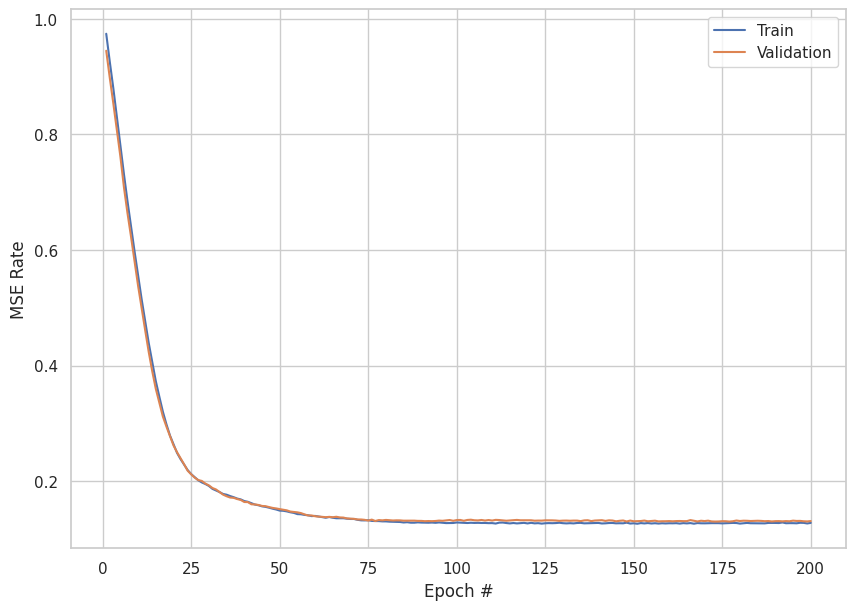

In [148]:
#TODO: Write code to plot the training and vadliation errors (MER) over epochs
import matplotlib.pyplot as plt
def plot_errors(train_errors, valid_errors, num_epochs):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), train_errors, label='Train')
    plt.plot(range(1, num_epochs + 1), valid_errors, label='Validation')
    plt.xlabel('Epoch #')
    plt.ylabel('MSE Rate')
    plt.legend()
    plt.show()

plot_errors(train_errors, valid_errors, num_epochs = 200)

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations.

In [149]:
# Build a feed-forward network
import torch.nn as nn
model = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

Let's print out the model achitecture.

In [150]:
model

Sequential(
  (0): Linear(in_features=109, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [151]:
model = model.to(device)

In [152]:
#TODO: write code to train the MLP network and save training and validation error.
train_losses, train_errors, valid_losses, valid_errors = train(model, train_loader, valid_loader, num_epochs=200, learning_rate=0.001)

Epoch: 1/200 - Train Loss: 8.4805, Train Error: 0.33 - Val Loss: 2.8010, Val Error: 0.18
Epoch: 21/200 - Train Loss: 1.1284, Train Error: 0.09 - Val Loss: 1.3593, Val Error: 0.10
Epoch: 41/200 - Train Loss: 0.8831, Train Error: 0.09 - Val Loss: 1.4007, Val Error: 0.11
Epoch: 61/200 - Train Loss: 0.7193, Train Error: 0.08 - Val Loss: 1.4810, Val Error: 0.12
Epoch: 81/200 - Train Loss: 0.5950, Train Error: 0.07 - Val Loss: 1.5034, Val Error: 0.10
Epoch: 101/200 - Train Loss: 0.5106, Train Error: 0.07 - Val Loss: 1.5665, Val Error: 0.11
Epoch: 121/200 - Train Loss: 0.4566, Train Error: 0.06 - Val Loss: 1.5632, Val Error: 0.10
Epoch: 141/200 - Train Loss: 0.4362, Train Error: 0.06 - Val Loss: 1.6072, Val Error: 0.10
Epoch: 161/200 - Train Loss: 0.3826, Train Error: 0.06 - Val Loss: 1.6142, Val Error: 0.10
Epoch: 181/200 - Train Loss: 0.3699, Train Error: 0.06 - Val Loss: 1.6861, Val Error: 0.12


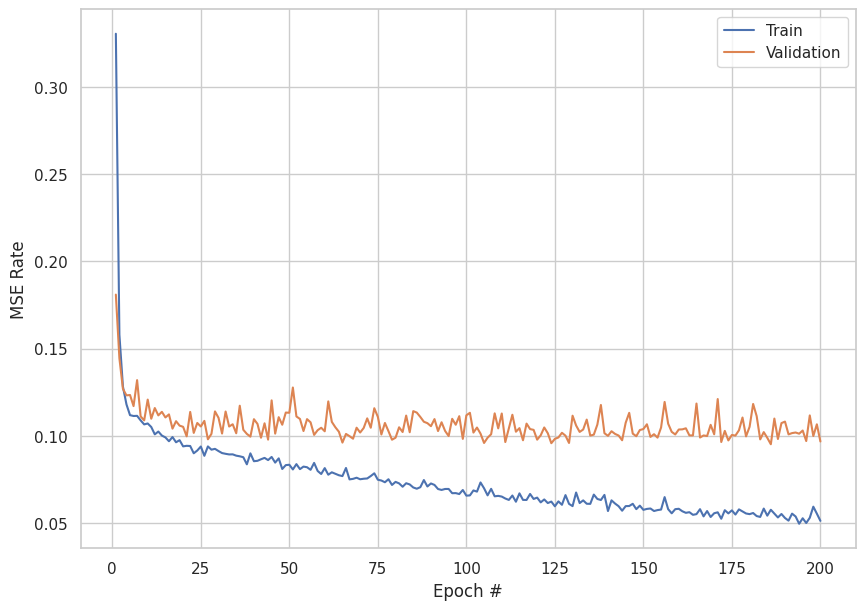

In [153]:
#TODO: Write code to plot the training and validation error (MER) over epochs
plot_errors(train_errors, valid_errors, num_epochs=200)

---
## Change network architecture


In the following, build a MLP with 4 hidden layer of sizes 512, 256, 128, 64, respectively.  

In [154]:
#TODO: building a MLP with 4 hidden layer of sizes 512, 256, 128, 64
import torch.nn as nn
four_layer_model = nn.Sequential(nn.Linear(train_features.shape[1], 512),
                      nn.ReLU(),
                      nn.Linear(512,256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,1))

In [155]:
four_layer_model = four_layer_model.to(device)
train_losses, train_errors, valid_losses, valid_errors = train(four_layer_model, train_loader, valid_loader, num_epochs=200, learning_rate=0.001)

Epoch: 1/200 - Train Loss: 8.5168, Train Error: 0.32 - Val Loss: 2.7834, Val Error: 0.18
Epoch: 21/200 - Train Loss: 0.9748, Train Error: 0.09 - Val Loss: 1.3847, Val Error: 0.12
Epoch: 41/200 - Train Loss: 0.6580, Train Error: 0.08 - Val Loss: 1.4457, Val Error: 0.10
Epoch: 61/200 - Train Loss: 0.5150, Train Error: 0.07 - Val Loss: 1.4897, Val Error: 0.11
Epoch: 81/200 - Train Loss: 0.4648, Train Error: 0.07 - Val Loss: 1.5408, Val Error: 0.10
Epoch: 101/200 - Train Loss: 0.4222, Train Error: 0.07 - Val Loss: 1.5620, Val Error: 0.10
Epoch: 121/200 - Train Loss: 0.3663, Train Error: 0.06 - Val Loss: 1.5510, Val Error: 0.10
Epoch: 141/200 - Train Loss: 0.3649, Train Error: 0.06 - Val Loss: 1.6003, Val Error: 0.10
Epoch: 161/200 - Train Loss: 0.2898, Train Error: 0.05 - Val Loss: 1.5725, Val Error: 0.09
Epoch: 181/200 - Train Loss: 0.3227, Train Error: 0.05 - Val Loss: 1.5755, Val Error: 0.10


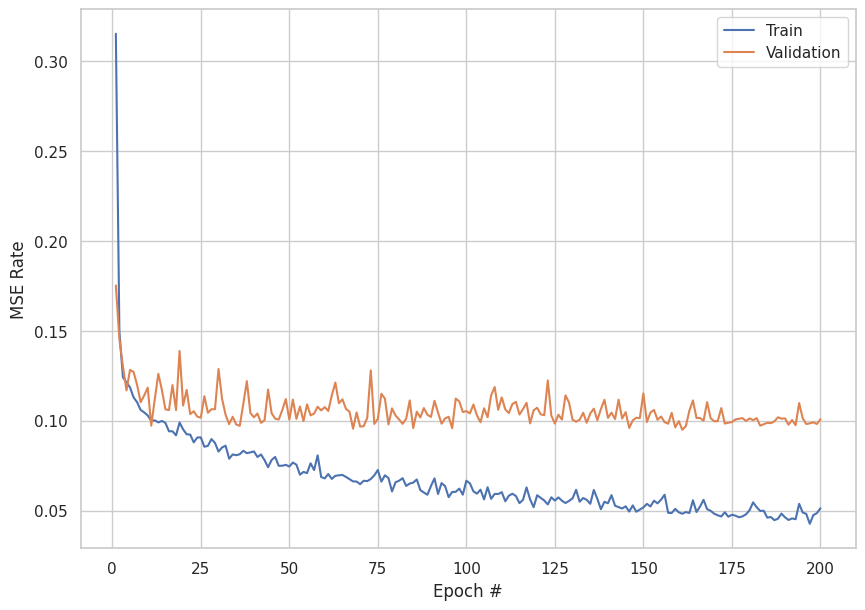

In [156]:
#TODO: plot the training and validation error (MER) over epochs
plot_errors(train_errors, valid_errors, num_epochs=200)

---
## Add norm regularization

In the following, use the norm regularization to retrain the above MLP.

In [157]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization (Post-Lasso + Early Stoppage)
X_train = train_features.clone().detach().cpu().numpy()
X_val   = valid_features.clone().detach().cpu().numpy()
X_test   = test_features.clone().detach().cpu().numpy()

In [158]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

# Add poly features
poly = PolynomialFeatures(interaction_only = True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly   = poly.transform(X_val)
X_test_poly  = poly.transform(X_test)

# Scale before lasso
poly_scaler = StandardScaler().fit(X_train_poly)
X_train_poly_s = poly_scaler.transform(X_train_poly)
X_val_poly_s   = poly_scaler.transform(X_val_poly)
X_test_poly_s  = poly_scaler.transform(X_test_poly)


In [159]:
# Fit LASSO (L1 regression) to select useful features
lasso_cv = LassoCV(cv=5, n_jobs=-1, max_iter=20000, random_state=42)
lasso_cv.fit(X_train_poly_s, train_labels)

# Keep non-zero coefficient features
selected = np.abs(lasso_cv.coef_) > 1e-8
selected_idx = np.where(selected)[0]
X_train_sel = X_train_poly_s[:, selected_idx]
X_val_sel   = X_val_poly_s[:, selected_idx]
X_test_sel = X_test_poly_s[:, selected_idx]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [160]:
train_ds = TensorDataset(torch.tensor(X_train_sel, dtype=torch.float32),
                         torch.tensor(np.asarray(train_labels).reshape(-1,1), dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val_sel, dtype=torch.float32),
                         torch.tensor(np.asarray(valid_labels).reshape(-1,1), dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test_sel, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

In [161]:
criterion = nn.L1Loss()

In [162]:
def train(model, train_loader, valid_loader, num_epochs=200, learning_rate=0.001, patience=10):
    train_losses, train_errors, valid_losses, valid_errors = [], [], [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        tot_train_loss = 0.0
        train_error_rates = torch.tensor([]).to(device)

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            output = model(features)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()
            train_error_rate = torch.abs(output / labels - 1)
            train_error_rates = torch.cat((train_error_rates, train_error_rate), dim=0)

        train_loss = tot_train_loss / len(train_loader)
        train_error = torch.median(train_error_rates).item()
        train_losses.append(train_loss)
        train_errors.append(train_error)

        # Validation Testing
        model.eval()
        tot_val_loss = 0.0
        val_error_rates = torch.tensor([]).to(device)

        with torch.no_grad():
            for features, labels in valid_loader:
                features, labels = features.to(device), labels.to(device)
                output = model(features)
                loss = criterion(output, labels)
                tot_val_loss += loss.item()
                val_error_rate = torch.abs(output / labels - 1)
                val_error_rates = torch.cat((val_error_rates, val_error_rate), dim=0)

        val_loss = tot_val_loss / len(valid_loader)
        val_error = torch.median(val_error_rates).item()
        valid_losses.append(val_loss)
        valid_errors.append(val_error)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_state)
                break

        if epoch % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Err: {train_error:.2f}, Val Err: {val_error:.2f}")

    return model, train_losses, train_errors, valid_losses, valid_errors

## **WITHOUT DROP LAYER**

In [163]:
input_dim = X_train_sel.shape[1]

four_layer_model_with_dropout = nn.Sequential(
    nn.Linear(input_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(device)

In [164]:
four_layer_model_with_dropout, train_losses, train_errors, valid_losses, valid_errors = train(
    four_layer_model_with_dropout, train_loader, valid_loader,
    num_epochs=200, learning_rate=0.001, patience=15
)

Epoch 1/200 | Train Loss: 1.1984, Val Loss: 1.7141, Train Err: 0.16, Val Err: 0.12
Epoch 21/200 | Train Loss: 0.5928, Val Loss: 1.3954, Train Err: 0.08, Val Err: 0.11
Epoch 41/200 | Train Loss: 0.5440, Val Loss: 1.3299, Train Err: 0.07, Val Err: 0.09
Epoch 61/200 | Train Loss: 0.4925, Val Loss: 1.2594, Train Err: 0.06, Val Err: 0.09
Epoch 81/200 | Train Loss: 0.4519, Val Loss: 1.2432, Train Err: 0.05, Val Err: 0.09
Epoch 101/200 | Train Loss: 0.4034, Val Loss: 1.2105, Train Err: 0.05, Val Err: 0.09
Epoch 121/200 | Train Loss: 0.3655, Val Loss: 1.1840, Train Err: 0.04, Val Err: 0.09
Epoch 141/200 | Train Loss: 0.3424, Val Loss: 1.1998, Train Err: 0.04, Val Err: 0.09
Early stopping at epoch 154


ValueError: x and y must have same first dimension, but have shapes (32,) and (154,)

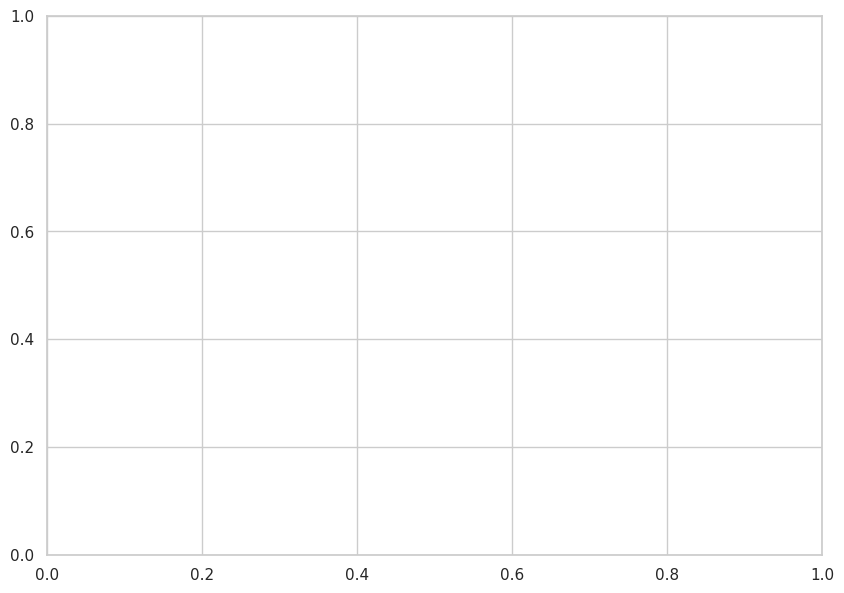

In [165]:
plot_errors(train_errors, valid_errors, num_epochs=32)

---
## Add dropout layer

In the following, add dropout layer to the above MLP.


In [166]:
input_dim = X_train_sel.shape[1]

four_layer_model_dropout = nn.Sequential(
    nn.Linear(input_dim, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 1)
).to(device)

In [167]:
print(input_dim)

526


In [168]:
four_layer_model_outliers_impute_inter, train_losses, train_errors, valid_losses, valid_errors = train(
    four_layer_model_dropout, train_loader, valid_loader,
    num_epochs=200, learning_rate=0.001, patience=15
)

Epoch 1/200 | Train Loss: 1.5758, Val Loss: 1.7469, Train Err: 0.24, Val Err: 0.14
Epoch 21/200 | Train Loss: 0.8078, Val Loss: 0.9014, Train Err: 0.12, Val Err: 0.11
Epoch 41/200 | Train Loss: 0.7259, Val Loss: 0.8234, Train Err: 0.10, Val Err: 0.11
Epoch 61/200 | Train Loss: 0.6567, Val Loss: 0.7923, Train Err: 0.09, Val Err: 0.10
Early stopping at epoch 74


ValueError: x and y must have same first dimension, but have shapes (68,) and (74,)

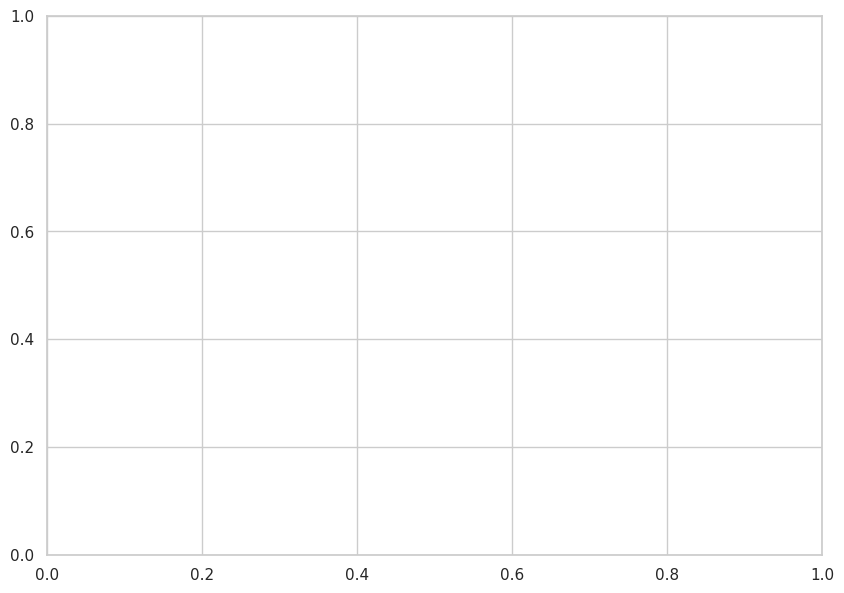

In [169]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
plot_errors(train_errors, valid_errors, num_epochs = 68)
print("Last validation error:", valid_errors[-1])

## Some other model variations

**You're more than welcome to try some other model varations (e.g. different number of hidden layers, hidden neurons, learning rate, etc) to achieve lower valid error. Include a table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.**

##**IDEATION**

In [170]:
# Check Skew of Positive Features to assess whether we need to log transform
train_check = pd.read_csv("train.csv")
train_check.skew(numeric_only=True).sort_values(ascending=False)

,0
UNITS,12.316644
GRD_AREA,6.956156
RM_AGE,2.167203
SALE_PRICE,1.758347
LIVING_SQFT,1.539907
FBSMT_SQFT,1.216529
STORY,1.054879
LAND_SQFT,0.983389
BSMT_AREA,0.967587
HLF_B,0.815118


In [171]:
cols_to_transform = ['UNITS', 'GRD_AREA', 'RM_AGE', 'LIVING_SQFT', 'FBSMT_SQFT']

for col in cols_to_transform:
    train_check[col] = np.log1p(train_check[col])

In [172]:
## Didn't work out, Valid Error: 0.10678088665008545

In [173]:
train_check.SALE_PRICE.sort_values(ascending = False).head(10)

,SALE_PRICE
10633,1995000
5947,1994100
6899,1992865
1921,1965000
8565,1964716
2237,1960000
8006,1950000
4501,1950000
8570,1950000
7306,1950000


In [174]:
upper_limit = train_check['SALE_PRICE'].quantile(0.99)  # top 1%

outliers_high = (train_check['SALE_PRICE'] > upper_limit).sum()

print(f"High outliers: {outliers_high}")
print(f"Remove prices above: ${upper_limit:,.0f}")

High outliers: 116
Remove prices above: $1,585,800


In [ ]:
# Worked Well: Error 0.1001

In [ ]:
# Impute by Neighborhood + Room Mean

# Works even better. Valid Error: 0.09630423784255981


In [ ]:
# Interaction Terms for All

# Valid Error: 0.10242283344268799

Checking boost models (cat boost, adaboost, xgboost, light gbm)


Cat boost(0.1186) and Adaboost(0.1036), light_gbm(0.902) were not as successful but the xgboost showed great promise (0.8467)

In [175]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

n_folds = 5
random_state = 42

# Assign X_proc and y from existing processed data
X_proc = X_train_sel
y = train_labels.cpu().numpy().flatten() # Convert PyTorch tensor to numpy array and flatten for scikit-learn

#cross validation with XGB Regressor
xgb_cv_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6,
                     subsample=0.8, colsample_bytree=0.8,
                     random_state=random_state, verbosity=0, n_jobs=1)

#kfold validation with XGB Regressor
kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

kf_xgb_scores = cross_val_score(
    xgb_cv_model,
    X_proc,     # preprocessed training features
    y,
    scoring="neg_mean_absolute_error",
    cv=kf,
    n_jobs=-1)

#interpreting model with mae.
mean_kf_mae = -kf_xgb_scores.mean()

print(f"MAE ({n_folds}-fold): {mean_kf_mae:.5f}")

#train model
xgb_cv_model.fit(X_proc, y)

MAE (5-fold): 0.72046


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=1, num_parallel_tree=None, ...)

---
## Save Model

Save a `checkpoint.pth` file containing all the necessary information to retrieve your best model and predictions. Remember submitting this file to Canvas siste.

Hint: Check out the `Lecture 4 - Saving and Loading Models.ipynb` on Canvas if you do not know how to save model.

In [176]:
import helper
import fc_model

In [177]:
print("Our model: \n\n", four_layer_model_outliers_impute_inter, '\n')
print("The state dict keys: \n\n", four_layer_model_outliers_impute_inter.state_dict().keys())

Our model: 

 Sequential(
  (0): Linear(in_features=526, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=256, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=64, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.2, inplace=False)
  (18): Linear(in_features=64, out_features=1, bias=True)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias', '12.weight', '12.bias', '15.weight', '15.bias', '18.weight', '18.bias'])


In [178]:
torch.save(four_layer_model_dropout.state_dict(), 'checkpoint.pth')

## Loading Model Back In (Only Run When we want an old model back in)

In [179]:
import torch.nn as nn

def load_checkpoint(filepath):
    # Recreate the model architecture that was saved
    # This must match the architecture of four_layer_model_dropout from cell S9mpcwQi2flh
    # The input_dim was determined to be 526 in cell A3gBTxvvSsbB
    input_dim = 526 # Ensure input_dim is correctly set based on your processed features

    model = nn.Sequential(
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(64, 1)
    ).to(device) # Ensure the model is moved to the correct device

    model.load_state_dict(torch.load(filepath)) # Load the state_dict directly
    model.eval() # Set to evaluation mode after loading
    return model

In [180]:
model = load_checkpoint('checkpoint.pth')
print(model)

Sequential(
  (0): Linear(in_features=526, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=256, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=64, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.2, inplace=False)
  (18): Linear(in_features=64, out_features=1, bias=True)
)


---
## Inference on test data

After the model is trained, we can use it for inference.

In [ ]:
#TODO: write the code to generate predicted sale prices for test data
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    # In evaluation (or testing) mode, we don't want any parameter updates. We want the model to give
    # the final output based on current parameter values.
    pred_labels = torch.tensor([]).to(device)
    with torch.no_grad():
      for features, in test_loader:
            # Move data to device (GPU or CPU)
            features = features.to(device)
            output = model(features)  # Compute the output
            # store prediction results
            pred_labels = torch.cat( (pred_labels,output),dim=0)
    return  pred_labels

pred_labels =test(four_layer_model_outliers_impute_inter,test_loader)
pred_labels=pred_labels*normalization_factor

In [ ]:
pred_labels[:20]

In [ ]:
#TODO: save the predicted sale prices into submission_csv
data = {'ID': test_ID, 'SALE_PRICE': pred_labels.cpu().numpy().squeeze()}
pred_df=pd.DataFrame(data)
pred_df.head()

pred_df.to_csv('submission_MAE.csv', index=False)

Now, we can submit our predictions on Kaggle and see how they compare with the actual house prices (labels) on the test set.

- Log in to the Kaggle website and visit the house price prediction competition page.

- Click the “Submit Predictions”.

- Click the “Browse Files” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.

- Click the “Submit” button at the bottom of the page to view your results.

 **Include your best test error shown on Kaggle in your case report!**

In [ ]:
import pandas as pd

# Read each CSV individually
df1 = pd.read_csv("submission_four_layer.csv")
df2 = pd.read_csv("submission_four_layer_lasso_early.csv")
df3 = pd.read_csv("submission_four_layer_lasso_early_dropout.csv")
df4 = pd.read_csv("submission_total_outliers_impute_inter_poly.csv")
df5 = pd.read_csv("submission_total_newest_gitvars.csv")
df6 = pd.read_csv("submission_total_outliers.csv")
df7 = pd.read_csv("submission_total_outliers_impute.csv")
df8 = pd.read_csv("submission_total_outliers_impute_inter.csv")

# Optional: normalize column names just in case (lowercase)
for df in [df1, df2, df3, df4, df5, df6, df7, df8, df9]:
    df.columns = df.columns.str.lower()

# Check that all have same ID order
for i, df in enumerate([df2, df3, df4, df5, df6, df7, df8, df9], start=2):
    if not (df1['id'].equals(df['id'])):
        print(f"⚠️ ID mismatch in df{i}")

# Stack all sale_price columns and take mean
import numpy as np

sale_prices = np.column_stack([
    df1['sale_price'],
    df2['sale_price'],
    df3['sale_price'],
    df4['sale_price'],
    df5['sale_price'],
    df6['sale_price'],
    df7['sale_price'],
    df8['sale_price']
])

avg_price = sale_prices.mean(axis=1)

# Create final averaged submission
avg_submission = pd.DataFrame({
    'ID': df1['id'],
    'SALE_PRICE': np.round(avg_price, 2)
})

# Save
avg_submission.to_csv("submission_minus_log.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np

# Read each CSV individually
df1 = pd.read_csv("submission_total_outliers_impute_inter.csv")
df2 = pd.read_csv("submission_total_outliers_impute.csv")
df3 = pd.read_csv("submission_four_layer.csv")
df4 = pd.read_csv("submission_total_outliers.csv")
df5 = pd.read_csv("submission_MAE.csv")

# Normalize column names just in case
for df in [df1, df2, df3, df4, df5]:
    df.columns = df.columns.str.lower()

df5_weight = 0.5
n_other = 4
other_weight = (1 - df5_weight) / n_other

weights = np.array([other_weight, other_weight, other_weight, other_weight, df5_weight])
print(f"Weights used: {weights} (sum = {weights.sum():.2f})")

# Stack sale_price columns
sale_prices = np.column_stack([
    df1['sale_price'],
    df2['sale_price'],
    df3['sale_price'],
    df4['sale_price'],
    df5['sale_price']
])

# Weighted average
avg_price = np.average(sale_prices, axis=1, weights=weights)

# Create final averaged submission
avg_submission = pd.DataFrame({
    'ID': df1['id'],
    'SALE_PRICE': np.round(avg_price, 2)
})

# Save
avg_submission.to_csv("submission_top5_weightedfor5a.csv", index=False)

---
## Evaluate the profit of iBuyer business model


In class, we have dicussed the iBuyer business model and its opportunities and risks. In the following analysis, imagine you work in a consulting firm and would like to investigate the profitability of the iBuyer business model.

You have taken the Mordern Analytics course and remembered that Prof. X advocated the data-driven approach in business decision making. Thus, you would like to perform analysis based on model and data.

Note that since we do not know the true sale prices in the future (like test data), we need to conduct the analysis based on the historical data (train or validation data). Previously, you have already trained a multilayer perceptron model using the train data. Now, let's evaluate the profit of iBuyer business model based on the predicted prices on the **validation data**.

Let's first compute the predicted prices on the valid data.

In [181]:
## TODO: Load your best model from your saved checkpoint.pth file.

import helper
import fc_model

model = load_checkpoint('checkpoint.pth')
print(model)

Sequential(
  (0): Linear(in_features=526, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=256, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=64, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.2, inplace=False)
  (18): Linear(in_features=64, out_features=1, bias=True)
)


In [182]:
## TODO: compute the predicted prices on valid data using your best model

model.eval()

valid_preds_tensor = torch.tensor([]).to(device)
with torch.no_grad():
    for features, _ in valid_loader:
        features = features.to(device)
        output = model(features)
        valid_preds_tensor = torch.cat((valid_preds_tensor, output), dim=0)

valid_pred = valid_preds_tensor.squeeze()

Compute the signed error rates (without taking the absolute value sign), that is

$$
\text{Signed Error Rate} = \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}}
$$
We will call signed error rate as prediction error henceafter.

In [200]:
## TODO: compute the signed error rates (henceafter called prediction errors)

valid_labels = valid_labels.to(device)

prediction_errors = (valid_pred - valid_labels) / valid_labels
avg_prediction_error = prediction_errors.mean()

print("Average prediction errors:", avg_prediction_error)
print("Sample prediction errors:", prediction_errors[:5])


Average prediction errors: tensor(0.2650, device='cuda:0')
Sample prediction errors: tensor([[ 0.2883,  3.1927,  2.5361,  ...,  7.3096,  3.2261,  2.4470],
        [-0.6831,  0.0314, -0.1302,  ...,  1.0441,  0.0396, -0.1521],
        [-0.5885,  0.3393,  0.1296,  ...,  1.6545,  0.3500,  0.1011],
        [-0.8381, -0.4730, -0.5556,  ...,  0.0444, -0.4688, -0.5668],
        [-0.7007, -0.0259, -0.1785,  ...,  0.9305, -0.0182, -0.1992]],
       device='cuda:0')


### Analysis and visualization of valid errors

Let's plot the histogram of prediction errors.

**Question 1**: what is the bias of the prediction errors? Include the histogram of prediction errors and the bias in your report.

Q1 — Bias (mean signed error): 0.0444 (4.44%)


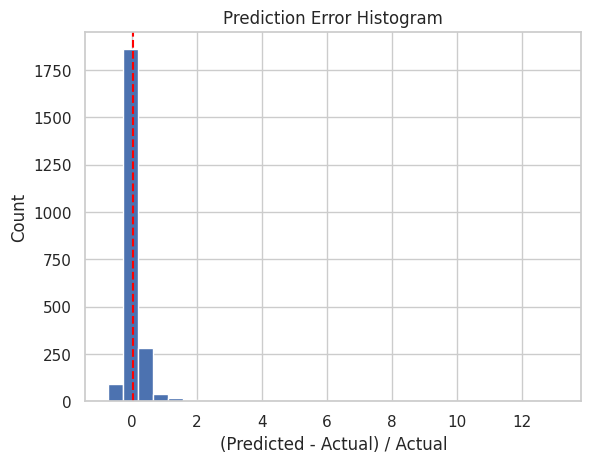

In [199]:
import numpy as np
import matplotlib.pyplot as plt

preds = valid_pred.detach().cpu().numpy().ravel()
labels = valid_labels.detach().cpu().numpy().ravel()

# Bias of prediction errors
signed_err = (preds - labels) / labels
bias = signed_err.mean()

print(f"Q1 — Bias (mean signed error): {bias:.4f} ({bias*100:.2f}%)")

# Histogram for bias
plt.hist(signed_err, bins=30)
plt.axvline(bias, color='red', linestyle='--')
plt.title("Prediction Error Histogram")
plt.xlabel("(Predicted - Actual) / Actual")
plt.ylabel("Count")
plt.show()

### Profit Analysis

In the following profit analysis, we assume the iBuyer will make an offer to every property in the valid data based on their predicted price $PP$. We assume the iBuyer decides the offer price $OP$ according to
$$
OP = \frac{PP}{1+\alpha},
$$
where $\alpha$ is the (targted) profit margin of the iBuyer.
Here we assume the profit margin has already taken into consideration the commission fee charged by the iBuyer
and various costs associated such as transaction cost, administration cost, and holding cost. Note that the commission fee charged by Zillow is often around $7.5\%$ and Zillow may charge additional repair costs after home inspection. Thus we take $\alpha=12\%$ in this case study.

We further assume that the iBuyer can resell the property at the same
price as the broker in the future once the property is bought. In other words, the resell price is equal to the sale price in the valid data. This assumption may not be exactly true in practice and the iBuyer may sell the house at either a higher or lower price depending on the market trend. But our conclusion will not change too much.

Based on the above two assumptions, we can now determine the percentage profit
for a property bought by the iBuyer as
$$
\frac{SP- OP}{OP}.
$$
We use the percentage profit instead of the absolute profit because the iBuyer cannot hope to purchase all houses in the market. Therefore, the percentage profit is a better measure of the profitability of the iBuyer business model.
 The aim of the iBuyer in this simplified setting is to purchase properties for less money than they are sold for, to generate a profit.

In [194]:
profit_margin = 0.12
preds = valid_pred.detach().cpu().numpy().ravel()
labels = valid_labels.detach().cpu().numpy().ravel()

offer = preds / (1 + profit_margin)
profit = (labels - offer) / offer

print(f"\nQ2 — Mean profit (all accepted): {profit.mean():.4f} ({profit.mean()*100:.2f}%)")


Q2 — Mean profit (all accepted): 0.1330 (13.30%)


**Question 2**: Consider the hypothetical scenario where the offers are all accepted regardless of their values,
what is the average percentage profit? Do you see a big difference compared to the profit margin $\alpha$? Include your answers in the report.

**Offer Acceptance Rule**


However, not every offer will be accepted by the home owner. Given an offer price, whether the homeowner accepts it
depends on the homeowner's perceived valuation. For the current dataset, we lack enough data to determine the homeowner's perceived valuation of the property. However, the actual sale price in the valid data serves as a reasonable proxy of the homeowner's perceived valuation. Therefore, we assume that the home owner will accept the offer, if
$$
OP> (1-\beta) SP,
$$
where $\beta$ is a discounting factor. Here the discounting factor captures the commission fee charged
by the conventional realtors which is around 6%, as well as the convenience factor that models
how much the homeowner values the quick transaction services of the iBuyer over the conventional
relator. We assume $\beta = 10\%$ in this case.

**Question 3**: Based on the sale price in the valid data and the acceptance rule, what is the mean percentage profit among all accepted offers? Do you see a big difference compared to the targeted profit margin $\alpha$?  Include your answers in your report.  

In [201]:
profit_margin = 0.12
beta = 0.10
preds = valid_pred.detach().cpu().numpy().ravel()
labels = valid_labels.detach().cpu().numpy().ravel()


accepted = offer > (1 - beta) * labels
accepted_profit = (labels[accepted] - offer[accepted]) / offer[accepted]

print(f"\nQ3 — Accepted: {accepted.sum()}/{len(labels)} ({accepted.mean()*100:.1f}%)")
print(f"Q3 — Mean profit (accepted): {accepted_profit.mean():.4f} ({accepted_profit.mean()*100:.2f}%)")


Q3 — Accepted: 1091/2293 (47.6%)
Q3 — Mean profit (accepted): -0.0349 (-3.49%)


Let's plot the histogram of the prediction errors for those properties whose home owners accepted the offer.

**Question 4**: What is the bias of the prediction errors when restricting to those properties whose owners accepted the offer? Based on the histogram and bias, can you explain your answers to Question 3?


Q4 — Bias on accepted offers: 0.2162 (21.62%)


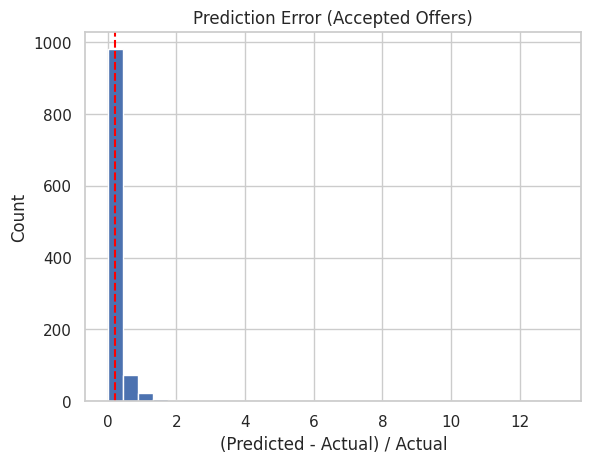

In [202]:

profit_margin = 0.12
beta = 0.10
preds = valid_pred.detach().cpu().numpy().ravel()
labels = valid_labels.detach().cpu().numpy().ravel()

signed_err_acc = (preds[accepted] - labels[accepted]) / labels[accepted]
bias_acc = signed_err_acc.mean()

print(f"\nQ4 — Bias on accepted offers: {bias_acc:.4f} ({bias_acc*100:.2f}%)")

plt.hist(signed_err_acc, bins=30)
plt.axvline(bias_acc, color='red', linestyle='--')
plt.title("Prediction Error (Accepted Offers)")
plt.xlabel("(Predicted - Actual) / Actual")
plt.ylabel("Count")
plt.show()